# Plot qPCR of RNA export with varying expression levels of exporter and supernatant

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_vary_expression"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [4]:
infile = "../preprocessed_data/qPCR_data/qPCR_vary_expression_Cq.csv"

cq_raw = pd.read_csv(infile, header=0)

columns_to_drop = ["Well Note", "Set Point"]
cq_raw.drop(columns_to_drop, axis=1, inplace=True)

print(cq_raw.shape)
cq_raw.head()

(26, 13)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
0,A09,SYBR,mCherry,Unkn-09,95C-1,NaN,21.400850,21.342406,0.057945,32298.666750,4.509185,33606.843670,1305.257102
1,A10,SYBR,mCherry,Unkn-10,95C-2,NaN,22.691929,22.897025,0.307961,13586.189060,4.133098,12002.582860,2322.214063
2,A11,SYBR,mCherry,Unkn-11,95C-3,NaN,23.383437,23.301107,0.079323,8544.043556,3.931663,9037.633991,479.138173
3,A12,SYBR,mCherry,Unkn-12,95C-4,NaN,22.536347,22.265443,0.291305,15080.585320,4.178418,18319.265510,3626.598129
4,B09,SYBR,mCherry,Unkn-09,95C-1,NaN,21.284973,21.342406,0.057945,34909.161230,4.542939,33606.843670,1305.257102


# Preprocess data

## Calculate total starting molecules

In [5]:
# Calculate normalization for input volume
DILUTION_FACTORS = (300/140) * (42/20) * (61/10) * (20/1)

In [6]:
# Back-calculate input RNA molecules, given <100% efficiency of extraction, DNase, RT, as measured based on RNA standard

PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [7]:
# Calculate total RNA molecules in supernatant
cq_raw["RNA molecules"] = cq_raw["Starting Quantity (SQ)"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules Mean"] = cq_raw["SQ Mean"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)
cq_raw["RNA molecules STD"] = cq_raw["SQ Std. Dev"] * DILUTION_FACTORS * (1/PROTOCOL_EFFICIENCY)

## Summarize replicates

In [8]:
groups = cq_raw.groupby(["Sample"])  # group samples by origin

summary = pd.DataFrame()

summary["mean SQ"] = groups["Starting Quantity (SQ)"].mean()  # Calculate mean over replicates
summary["std SQ"] = groups["Starting Quantity (SQ)"].std()  # Calculate mean over replicates

summary["RNA molecules"] = groups["RNA molecules"].mean()
summary["RNA molecules STD"] = groups["RNA molecules STD"].mean()

summary

,mean SQ,std SQ,RNA molecules,RNA molecules STD
Sample,,,,
95C-1,33606.843667,1305.257104,3.096796e+09,1.202766e+08
95C-11a,77.704080,41.305559,7.160259e+06,3.806216e+06
95C-2,12002.582858,2322.214063,1.106011e+09,2.139869e+08
95C-3,9037.633991,479.138173,8.327980e+08,4.415152e+07
95C-4,18319.265517,3626.598127,1.688080e+09,3.341830e+08
95C-5,10996.634560,1387.879242,1.013316e+09,1.278900e+08
NTC,14.870735,12.949680,1.370305e+06,1.044124e+06


## Censor by lower limit of quantification

In [9]:
# Lower limit of quantification is set based on maximum signal from no template control (NTC) wells.

LOD = cq_raw.set_index("Sample").loc["NTC", "RNA molecules"].max()

print("Lower limit of quantification:", LOD)

Lower limit of quantification: 2938391.452931963


In [10]:
# Substitute LOD for values below LOD

cq_raw["RNA molecules censored"] = cq_raw["RNA molecules"]
cq_raw.loc[cq_raw["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

summary["RNA molecules censored"] = summary["RNA molecules"]
summary.loc[summary["RNA molecules"] < LOD, "RNA molecules censored"] = LOD

## Calculate relative abundance (compared with appropriate references)

In [11]:
# Initialize columns

summary["RNA molecules censored relative to reference"] = np.nan

cq_raw["RNA molecules censored relative to reference"] = np.nan

In [12]:
# Calculate RNA molecules relative to reference

ref = summary.loc["95C-1", "RNA molecules censored"]  # set reference value
samples = ["95C-1", "95C-2", "95C-3", "95C-4", "95C-5", "95C-11a"]  # samples that use this reference value

summary.loc[samples, "RNA molecules censored relative to reference"] = summary.loc[samples, "RNA molecules censored"] / ref

In [13]:
# Repeat for raw Cq values

cq_raw = cq_raw.set_index("Sample")

ref = summary.loc["95C-1", "RNA molecules censored"]  # set reference value
samples = ["95C-1", "95C-2", "95C-3", "95C-4", "95C-5", "95C-11a"]  # samples that use this reference value

cq_raw.loc[samples, "RNA molecules censored relative to reference"] = cq_raw.loc[samples, "RNA molecules censored"] / ref

cq_raw = cq_raw.reset_index()

In [14]:
# Convert to percentage

summary["RNA molecules censored relative to reference %"] = summary["RNA molecules censored relative to reference"] * 100
cq_raw["RNA molecules censored relative to reference %"] = cq_raw["RNA molecules censored relative to reference"] * 100

# Visualize RNA export with varying expression of exporter Gag-MCP

In [15]:
# Choose samples
index_ordered = ["95C-1", "95C-2", "95C-3", "95C-11a"]

In [16]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[index_ordered]

print(summary_subset.shape)
summary_subset

(4, 7)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored,RNA molecules censored relative to reference,RNA molecules censored relative to reference %
Sample,,,,,,,
95C-1,33606.843667,1305.257104,3.096796e+09,1.202766e+08,3.096796e+09,1.000000,100.000000
95C-2,12002.582858,2322.214063,1.106011e+09,2.139869e+08,1.106011e+09,0.357147,35.714698
95C-3,9037.633991,479.138173,8.327980e+08,4.415152e+07,8.327980e+08,0.268922,26.892243
95C-11a,77.704080,41.305559,7.160259e+06,3.806216e+06,7.160259e+06,0.002312,0.231215


In [17]:
# Get data of replicates of selected wells
selector = cq_raw["Sample"].isin(index_ordered)
data = cq_raw.loc[selector]

print(data.shape)
data.head()

(12, 19)


,Sample,Well,Fluor,Target,Content,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,RNA molecules,RNA molecules Mean,RNA molecules STD,RNA molecules censored,RNA molecules censored relative to reference,RNA molecules censored relative to reference %
0,95C-1,A09,SYBR,mCherry,Unkn-09,NaN,21.400850,21.342406,0.057945,32298.666750,4.509185,33606.843670,1305.257102,2.976251e+09,3.096796e+09,1.202766e+08,2.976251e+09,0.961074,96.107409
1,95C-2,A10,SYBR,mCherry,Unkn-10,NaN,22.691929,22.897025,0.307961,13586.189060,4.133098,12002.582860,2322.214063,1.251937e+09,1.106011e+09,2.139869e+08,1.251937e+09,0.404269,40.426852
2,95C-3,A11,SYBR,mCherry,Unkn-11,NaN,23.383437,23.301107,0.079323,8544.043556,3.931663,9037.633991,479.138173,7.873147e+08,8.327980e+08,4.415152e+07,7.873147e+08,0.254235,25.423523
4,95C-1,B09,SYBR,mCherry,Unkn-09,NaN,21.284973,21.342406,0.057945,34909.161230,4.542939,33606.843670,1305.257102,3.216802e+09,3.096796e+09,1.202766e+08,3.216802e+09,1.038752,103.875156
5,95C-2,B10,SYBR,mCherry,Unkn-10,NaN,23.251152,22.897025,0.307961,9336.794244,3.970198,12002.582860,2322.214063,8.603649e+08,1.106011e+09,2.139869e+08,8.603649e+08,0.277824,27.782419


/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


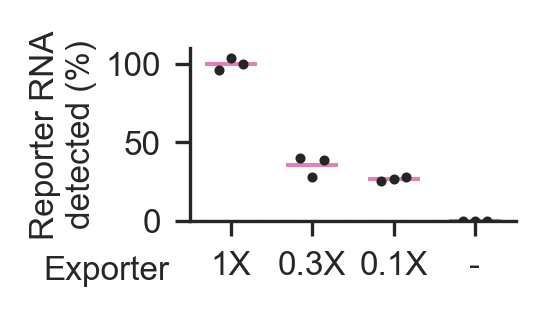

In [18]:
# Make simple swarm plot

field = "RNA molecules censored relative to reference %"

fig, ax = plt.subplots(1, 1, figsize=(1.4,0.75))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_ylim(0, 110)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.scatterplot(ax=ax, x=x, y=y, marker="_", s=150, color="#e082b5")

# Plot individual points as swarm (sort columns appropriately)

sample_to_rank = dict(zip(index_ordered, range(len(index_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = np.array([x[rank] for rank in data["rank"]])

x_offset = np.array([-0.15, 0, 0.15])  # jitter offsets to avoid operlaps
x_swarm_offset = x_swarm + np.tile(x_offset, int(len(x_swarm)/len(x_offset)))

ax.scatter(x_swarm_offset, y_swarm, color="#252525", s=2, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_ylabel("Reporter RNA\ndetected (%)", labelpad=2)

ax.set_yticks([0, 50, 100])

ax.set_xticks([0, 1, 2, 3])
xticklabels = ["1X", "0.3X", "0.1X", "-"]
ax.set_xticklabels(xticklabels)

ax.text(-0.75, -22, "Exporter", ha="right", va="top", size=FONTSIZE)

LOD = summary_subset.loc["95C-11a", field]
ax.axhline(LOD, lw=0.5, ls="--", color="k", zorder=-1)

ax.set_xlabel("")

sns.despine()

save_figure(fig, "vary_exporter_GagMCP")

# Visualize RNA export with varying expression of reporter

In [19]:
# Choose samples
index_ordered = ["95C-1", "95C-4", "95C-5", "95C-11a"]

In [20]:
# Get data of summary across replicates of selected wells
summary_subset = summary.loc[index_ordered]

print(summary_subset.shape)
summary_subset

(4, 7)


,mean SQ,std SQ,RNA molecules,RNA molecules STD,RNA molecules censored,RNA molecules censored relative to reference,RNA molecules censored relative to reference %
Sample,,,,,,,
95C-1,33606.843667,1305.257104,3.096796e+09,1.202766e+08,3.096796e+09,1.000000,100.000000
95C-4,18319.265517,3626.598127,1.688080e+09,3.341830e+08,1.688080e+09,0.545105,54.510521
95C-5,10996.634560,1387.879242,1.013316e+09,1.278900e+08,1.013316e+09,0.327214,32.721414
95C-11a,77.704080,41.305559,7.160259e+06,3.806216e+06,7.160259e+06,0.002312,0.231215


In [21]:
# Get data of replicates of selected wells
selector = cq_raw["Sample"].isin(index_ordered)
data = cq_raw.loc[selector]

print(data.shape)
data.head()

(12, 19)


,Sample,Well,Fluor,Target,Content,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,RNA molecules,RNA molecules Mean,RNA molecules STD,RNA molecules censored,RNA molecules censored relative to reference,RNA molecules censored relative to reference %
0,95C-1,A09,SYBR,mCherry,Unkn-09,NaN,21.400850,21.342406,0.057945,32298.66675,4.509185,33606.84367,1305.257102,2.976251e+09,3.096796e+09,1.202766e+08,2.976251e+09,0.961074,96.107409
3,95C-4,A12,SYBR,mCherry,Unkn-12,NaN,22.536347,22.265443,0.291305,15080.58532,4.178418,18319.26551,3626.598129,1.389643e+09,1.688080e+09,3.341830e+08,1.389643e+09,0.448736,44.873555
4,95C-1,B09,SYBR,mCherry,Unkn-09,NaN,21.284973,21.342406,0.057945,34909.16123,4.542939,33606.84367,1305.257102,3.216802e+09,3.096796e+09,1.202766e+08,3.216802e+09,1.038752,103.875156
7,95C-4,B12,SYBR,mCherry,Unkn-12,NaN,21.957315,22.265443,0.291305,22237.61125,4.347088,18319.26551,3626.598129,2.049147e+09,1.688080e+09,3.341830e+08,2.049147e+09,0.661699,66.169889
8,95C-1,C09,SYBR,mCherry,Unkn-09,NaN,21.341396,21.342406,0.057945,33612.70302,4.526503,33606.84367,1305.257102,3.097336e+09,3.096796e+09,1.202766e+08,3.097336e+09,1.000174,100.017435


/scratch/resources/anaconda3/envs/RNA_export_magic/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


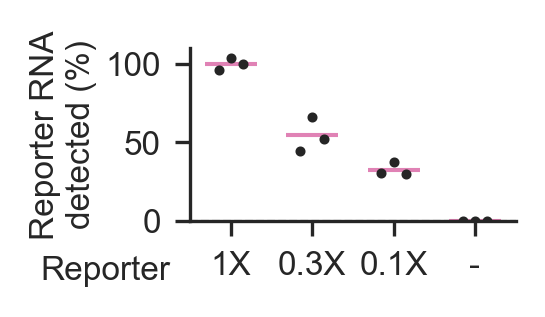

In [22]:
# Make simple swarm plot

field = "RNA molecules censored relative to reference %"

fig, ax = plt.subplots(1, 1, figsize=(1.4,0.75))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_ylim(0, 110)

# Plot summary

y = summary_subset[field]
x = np.arange(len(y))

sns.scatterplot(ax=ax, x=x, y=y, marker="_", s=150, color="#e082b5")

# Plot individual points as swarm (sort columns appropriately)

sample_to_rank = dict(zip(index_ordered, range(len(index_ordered))))
data["rank"] = [sample_to_rank[s] for s in data["Sample"]]
data = data.sort_values(by="rank")

y_swarm = data[field]
x_swarm = np.array([x[rank] for rank in data["rank"]])

x_offset = np.array([-0.15, 0, 0.15])  # jitter offsets to avoid operlaps
x_swarm_offset = x_swarm + np.tile(x_offset, int(len(x_swarm)/len(x_offset)))

ax.scatter(x_swarm_offset, y_swarm, color="#252525", s=2, zorder=10)

ax.set_xlim(min(x)-0.5, max(x)+0.5)

ax.set_ylabel("Reporter RNA\ndetected (%)", labelpad=2)

ax.set_yticks([0, 50, 100])

ax.set_xticks([0, 1, 2, 3])
xticklabels = ["1X", "0.3X", "0.1X", "-"]
ax.set_xticklabels(xticklabels)

ax.text(-0.75, -22, "Reporter", ha="right", va="top", size=FONTSIZE)

LOD = summary_subset.loc["95C-11a", field]
ax.axhline(LOD, lw=0.5, ls="--", color="k", zorder=-1)

ax.set_xlabel("")

sns.despine()

save_figure(fig, "vary_reporter_GagMCP")